In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

In [ ]:
STEPS = 50
STEP = 1/STEPS
CONST = (3 * np.cosh(np.sqrt((np.pi**2 + 1) / 3)) / (np.pi**2 + 1) - 3 / (np.pi**2 + 1)) / np.sinh(np.sqrt((np.pi**2 + 1) / 3))
EPSILON = 1/1000

In [ ]:
# двойное быстрое синус преобразование
def vector_dst(vector):
  matrix_x = np.stack([vector for _ in range(len(vector))])
  matrix_kn = np.arange(1,len(vector)+1).reshape(1,len(vector)) * np.arange(1,len(vector)+1).reshape(len(vector), 1)
  const = np.pi/(len(vector)+1)
  matrix_fi = matrix_kn*const
  matrix_sin = np.sin(matrix_fi)
  return np.sum(matrix_x * matrix_sin, axis = 1)
def dst(matrix):
  #return np.round(np.apply_along_axis(vector_dst, 0, matrix), 4)
  return np.apply_along_axis(vector_dst, 0, matrix)

# обратное
def vector_idst(vector):
  const = 2/(len(vector)+1)
  return const*vector_dst(vector)
def idst(matrix):
  #return np.round(np.apply_along_axis(vector_idst, 0, matrix), 4)
  return np.apply_along_axis(vector_idst, 0, matrix)

In [ ]:
# правая функция уравнения 
def right_function(steps=STEPS, step = STEP, first_index = 0):
  right_f = np.zeros((steps-1, steps-1))
  for id_y in range(first_index, steps-1):
      for id_x in range(first_index, steps-1):
        right_f[id_x, id_y] = 3 * step**2 * np.sin(np.pi * (id_x+1) * step)
  return right_f

In [ ]:
# реализует аналитическое решение на заданной сетке
def get_analytical_Uxy(steps=STEPS, step = STEP):
  U_x_y = np.zeros((steps+1, steps+1))
  for id_x in range(0, steps):
    for id_y in range(0, steps):
      U_x_y[id_x, id_y] = np.sin(np.pi * (id_x) * step) * (-3 * np.cosh((id_y) * step * np.sqrt((np.pi**2 + 1) / 3)) / (np.pi**2 + 1) + 3 / (np.pi**2 + 1) + CONST * np.sinh((id_y) * step * np.sqrt((np.pi**2 + 1) / 3)))
  return U_x_y

# решение методом ДБСП
def get_double_fast_sine_conversion_Uxy(steps=STEPS, step = STEP):
  right_f = right_function(steps, step)
  start_time = time.clock()
  first_sine_conversion = idst(idst(right_f.T).T)/step**2
  own_lambda = np.zeros((steps-1, steps-1))
  for m in range(0, steps-1):
      for k in range(0, steps-1):
          own_lambda[k, m] = step**2 / (4 * (np.sin(np.pi * (k+1) * step * 0.5))**2 + 12 * (np.sin(np.pi * (m+1) * step * 0.5))**2 + step**2)
  second_sine_conversion  = dst(dst((own_lambda * first_sine_conversion).T).T)
  end_time = time.clock()
  sin_conv_with_zeros = np.zeros((steps + 1, steps + 1))
  for id_y in range(0, steps-1):
      for id_x in range(0, steps-1):
          sin_conv_with_zeros[id_x + 1, id_y + 1] = second_sine_conversion[id_x, id_y]
  return sin_conv_with_zeros, (end_time - start_time)

# решение методом Якоби
def Jacobi_method(steps=STEPS, step = STEP, epsilon = EPSILON):
  U_x_y = get_analytical_Uxy(steps, step)
  time_start = time.clock()
  right_f = np.zeros((steps+1, steps+1))
  for id_y in range(1, steps):
      for id_x in range(1, steps):
          right_f[id_x, id_y] = 3 * step**2 * np.sin(np.pi * (id_x) * step)
  U_Jacobi = np.zeros((steps+1, steps+1))
  iterations = 0
  U_Jacobi_prev = U_Jacobi
  while np.amax(U_x_y - U_Jacobi) > epsilon :
    print(np.amax(U_x_y - U_Jacobi))
    for id_x in range(1, steps):
        for id_y in range(1, steps):
            U_Jacobi[id_x, id_y] = (right_f[id_x, id_y] + U_Jacobi_prev[id_x - 1, id_y] + U_Jacobi_prev[id_x + 1, id_y] + 3 * U_Jacobi_prev[id_x, id_y - 1] + 3 * U_Jacobi_prev[id_x, id_y + 1]) / (8 + step**2)
    iterations +=1
    U_Jacobi_prev = U_Jacobi
  time_end = time.clock()
  return U_Jacobi, (time_end - time_start), iterations

In [ ]:
# рисунок решения в 3D
def get_draw(u_x_y, title, grid_step):
  X, Y = np.mgrid[0:1:grid_step, 0:1:grid_step]
  fig = plt.figure(figsize=(15,10))
  ax = fig.add_subplot(111, projection='3d')
  ax.plot_surface(X, Y, u_x_y, cmap='inferno')
  ax.set_title(title)
  ax.legend()

No handles with labels found to put in legend.


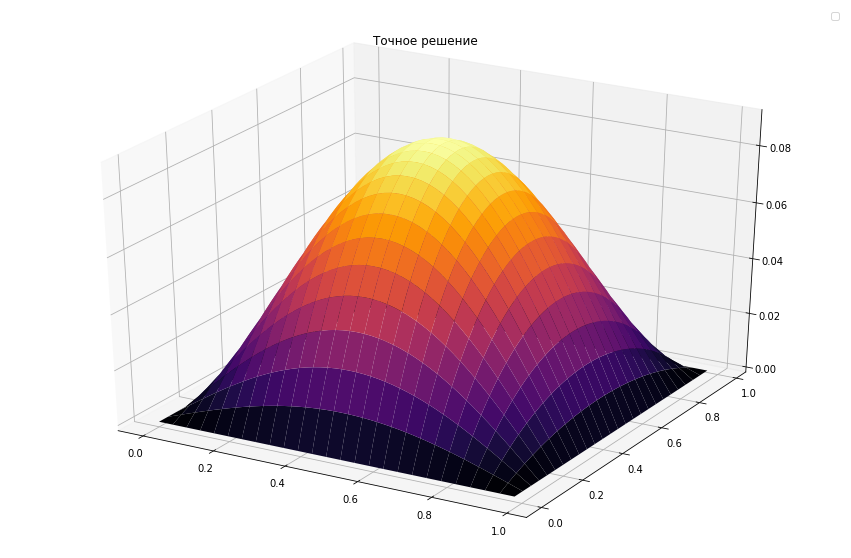

In [ ]:
analytical_Uxy = get_analytical_Uxy()
get_draw(analytical_Uxy, "Точное решение", 1/(STEPS+1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
No handles with labels found to put in legend.


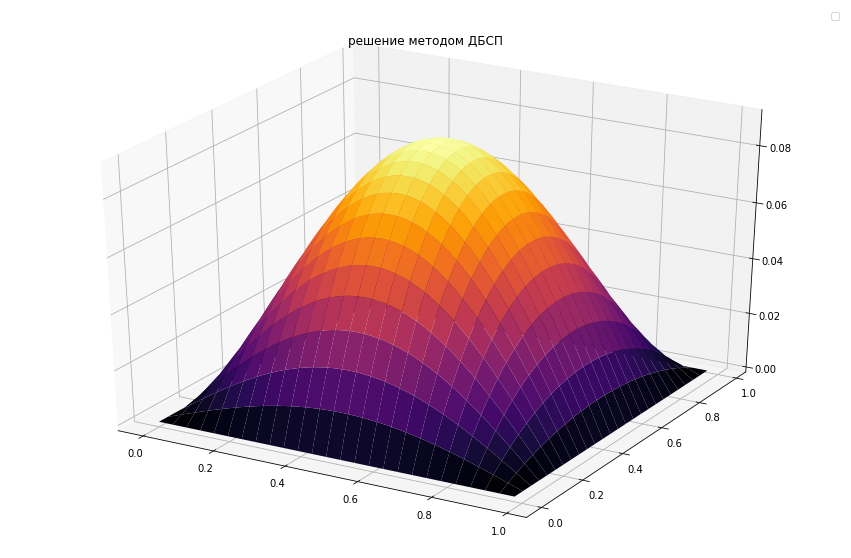

In [ ]:
sin_conv, del_time = get_double_fast_sine_conversion_Uxy()
get_draw(sin_conv, "решение методом ДБСП", 1/(STEPS+1))

No handles with labels found to put in legend.


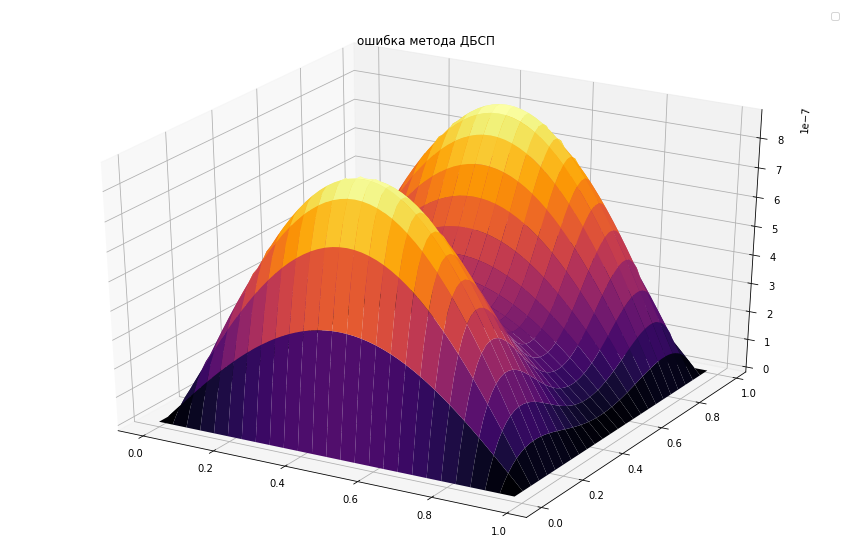

In [ ]:
get_draw(analytical_Uxy - sin_conv, "ошибка метода ДБСП", 1/(STEPS+1))

In [ ]:
u_jacobi, jacobi_time, iterations = Jacobi_method()
get_draw(u_jacobi, "метод Якоби", 1/(STEPS+1))

No handles with labels found to put in legend.


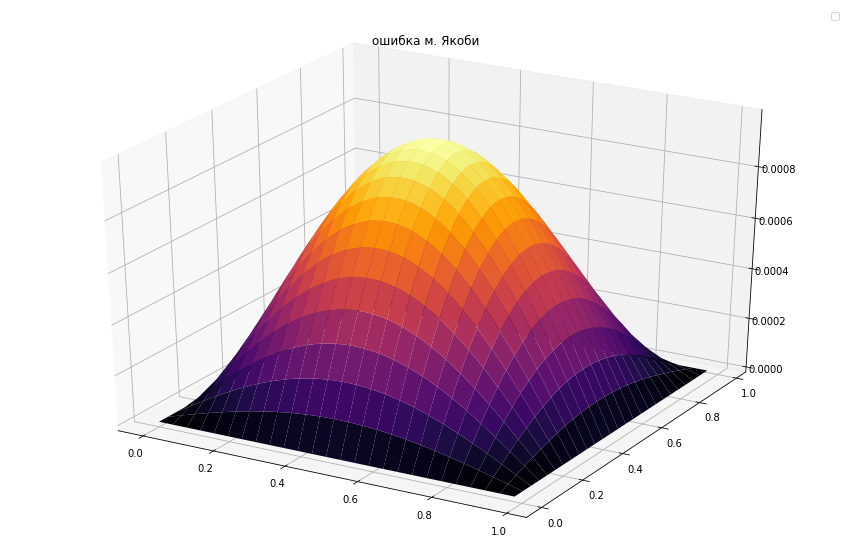

In [ ]:
get_draw(analytical_Uxy - u_jacobi, "ошибка м. Якоби", 1/(STEPS+1))

In [ ]:
# сравнение времени работы 
array_sine_time = []
array_jacobi_time = []
array_jacobi_iterations = []
array_n = [10, 25, 50, 75, 100, 150, 200, 250]
for steps in array_n:
  step = 1/steps
  _, sine_time = get_double_fast_sine_conversion_Uxy(steps, step)
  array_sine_time.append(sine_time)
  _, jacobi_time, iterations = Jacobi_method(steps, step)
  array_jacobi_time.append(jacobi_time)
  array_jacobi_iterations.append(iterations)

In [ ]:
import pandas as pd
pd.DataFrame({"Разбиение": array_n,
              "ДБСП (сек)": array_sine_time,
              "м.Якоби (сек)": array_jacobi_time,
              "итер м.Якоби": array_jacobi_iterations})

,Разбиение,ДБСП (сек),м.Якоби (сек),итер м.Якоби
0,10,0.0036,0.0394,45
1,25,0.0164,0.6613,281
2,50,0.0516,7.9050,1124
3,75,0.1359,36.5800,2528
4,100,0.2697,114.6529,4494
5,150,0.7470,573.9669,10110
6,200,1.6994,1796.4629,17974
7,250,2.9245,4282.3175,28084


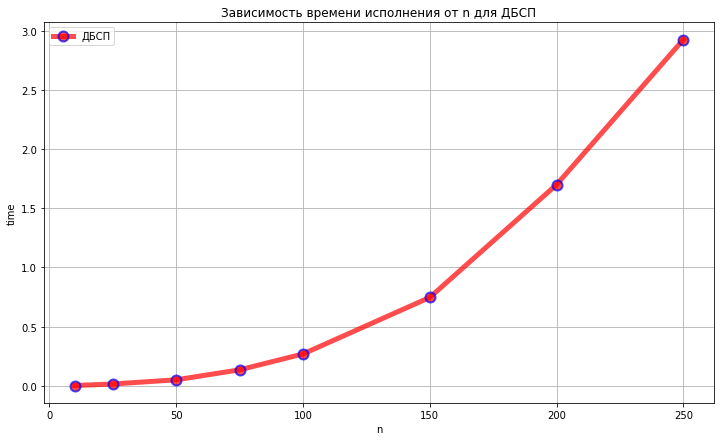

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(array_n, array_sine_time, 'o-r', alpha=0.7, label="ДБСП", lw=5, mec='b', mew=2, ms=10)
plt.xlabel("n")
plt.ylabel("time")
plt.title("Зависимость времени исполнения от n для ДБСП")
plt.legend()
plt.grid(True)

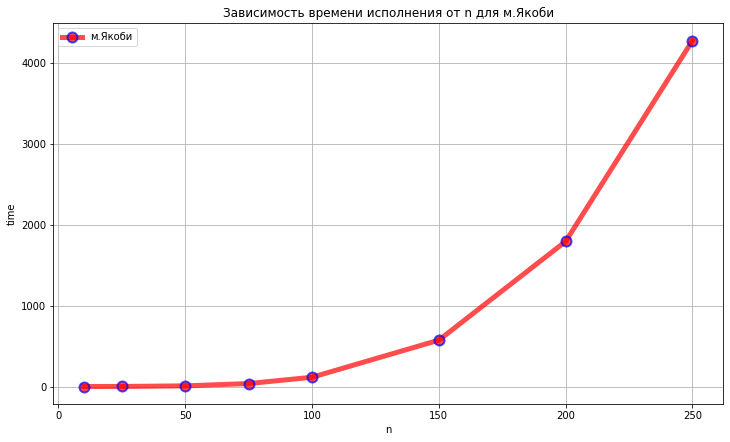

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(array_n, array_jacobi_time, 'o-r', alpha=0.7, label="м.Якоби", lw=5, mec='b', mew=2, ms=10)
plt.xlabel("n")
plt.ylabel("time")
plt.title("Зависимость времени исполнения от n для м.Якоби")
plt.legend()
plt.grid(True)